In [1]:
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import (
    train_test_split,
    KFold
)
import tensorflow.keras as keras
import tensorflow as tf

In [2]:
df = pd.read_csv('Datasets/star_classification.csv')

In [3]:
df = df.sample(frac=1)

In [4]:

df = df[[
    'alpha', 'delta', 'u', 'g', 'r', 'i', 'z',
        'class', 'redshift',
]].copy()
df = df.reset_index(drop=True)
df['class']

0          STAR
1        GALAXY
2           QSO
3           QSO
4           QSO
          ...  
99995    GALAXY
99996       QSO
99997    GALAXY
99998    GALAXY
99999    GALAXY
Name: class, Length: 100000, dtype: object

In [5]:
class_label = df.pop('class')
features = df

In [6]:
test_labels = keras.layers.CategoryEncoding(num_tokens=3,output_mode = 'one_hot')
test_labels = test_labels(pd.factorize(class_label,sort=True)[0])
class_label = test_labels

In [7]:
# convert to tensor 
features = tf.convert_to_tensor(features)
features

<tf.Tensor: shape=(100000, 8), dtype=float64, numpy=
array([[ 4.07228012e+00,  1.15155149e+01,  2.57469300e+01, ...,
         2.10183300e+01,  1.98176400e+01, -1.03112700e-04],
       [ 1.27490616e+02,  5.30139917e+01,  2.25283800e+01, ...,
         2.08636900e+01,  1.98201800e+01,  7.63565700e-01],
       [ 3.39088689e+02,  2.92200348e+00,  2.19714800e+01, ...,
         2.11552600e+01,  2.16536000e+01,  1.55839000e+00],
       ...,
       [ 2.21532369e+02,  4.14637909e+01,  2.18758400e+01, ...,
         1.95841200e+01,  1.90825400e+01,  6.62701400e-01],
       [ 2.55813880e+02,  3.58851893e+01,  2.39119000e+01, ...,
         1.99066200e+01,  1.92859300e+01,  7.30424500e-01],
       [ 2.06650827e+01, -2.18488574e+00,  2.37251400e+01, ...,
         2.12517900e+01,  2.08721700e+01,  8.60751500e-01]])>

In [8]:
#and feature normalizer
features_norm = keras.layers.Normalization(axis = -1)
features_norm.adapt(features)

In [9]:
def model_setup():
    model = keras.models.Sequential([
        features_norm,
        keras.layers.Dense(128,keras.activations.relu),
        keras.layers.Dense(256,keras.activations.relu),
        keras.layers.Dense(128, keras.activations.sigmoid),
        keras.layers.Dense(3)
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.CategoricalAccuracy()]
    )
    
    return model

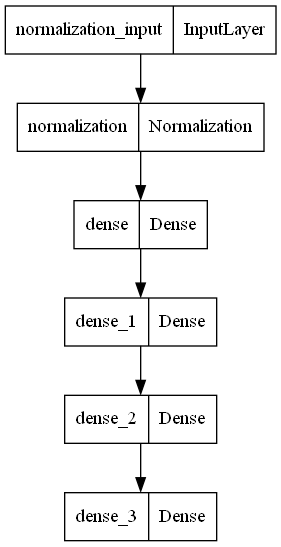

In [10]:
train_data = tf.data.Dataset.from_tensor_slices((features,class_label)).batch(50000)
model = model_setup()
model.build(input_shape = (None,9))
keras.utils.plot_model(model)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 8)                17        
 n)                                                              
                                                                 
 dense (Dense)               (None, 128)               1152      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 67,476
Trainable params: 67,459
Non-trainable params: 17
___________________________________________________

In [ ]:
tens_board = keras.callbacks.TensorBoard(
    log_dir="logs",
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    write_steps_per_second=True,
    update_freq="epoch",
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None,
)
md = model.fit(train_data,epochs=150,callbacks = tens_board)
md.history

Epoch 1/150
2/2 [==============================] - 1s 273ms/step - loss: 1.4466 - categorical_accuracy: 0.2159
Epoch 2/150
2/2 [==============================] - 0s 207ms/step - loss: 1.2469 - categorical_accuracy: 0.2170
Epoch 3/150
2/2 [==============================] - 0s 214ms/step - loss: 1.0874 - categorical_accuracy: 0.2338
Epoch 4/150
2/2 [==============================] - 0s 204ms/step - loss: 0.9747 - categorical_accuracy: 0.4547
Epoch 5/150
2/2 [==============================] - 0s 208ms/step - loss: 0.9099 - categorical_accuracy: 0.5788
Epoch 6/150
2/2 [==============================] - 0s 209ms/step - loss: 0.8772 - categorical_accuracy: 0.5987
Epoch 7/150
2/2 [==============================] - 0s 218ms/step - loss: 0.8526 - categorical_accuracy: 0.6190
Epoch 8/150
2/2 [==============================] - 0s 214ms/step - loss: 0.8232 - categorical_accuracy: 0.6605
Epoch 9/150
2/2 [==============================] - 0s 219ms/step - loss: 0.7897 - categorical_accuracy: 0.6957
E

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# ax = sns.lineplot(md.history['categorical_accuracy'],color = 'red',label ='categorical_accuracy' )
# sns.lineplot(md.history['loss'],label = 'loss')

# plt.show()

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs